### 🌸 annotation to xml

In [166]:
import xml.etree.ElementTree as ET

from music21 import stream, instrument, clef, meter, note, percussion
from music21.musicxml import m21ToXml

# 상수들
BARLINE = "barline"
NOTE = "note"
REST = "rest"
NOTEHEAD_X_LIST = ('G5', 'A5', 'D4')
STEM_DIRECTION_UP = "up"
DIVISION_CHORD = '+'
DIVISION_NOTE = '|'
DIVISION_DURATION = '_'
DIVISION_PITCH = '-'

# -- annotation dict key 값들
IS_NOTE = 'is_note'
NOTEHEAD = 'notehead'
NOTEHEAD_X = 'x'
PITCH = "pitch"
DURATION = "duration"

# -- duration type <-> quarterLength match dict
DURATION_TYPE_TO_LENGTH_TEMP = {
    "whole": 4.0,
    "half": 2.0,
    "quarter": 1.0,
    "eighth": 0.5,
    "16th": 0.25,
    "32nd": 0.125,
    "64th": 0.0625,
    "128th": 0.03125,
    "256th": 0.015625,
    "512th": 0.0078125,
    "1024th": 0.00390625,
    "breve": 8.0,
    "longa": 16.0,
    "maxima": 32.0,
}
DURATION_TYPE_TO_LENGTH = {}
for duration_type, quarter_length in DURATION_TYPE_TO_LENGTH_TEMP.items():
    DURATION_TYPE_TO_LENGTH[duration_type] = quarter_length
    DURATION_TYPE_TO_LENGTH[duration_type + '.'] = quarter_length + quarter_length / 2


In [167]:

"""
result dict

[
    # 마디
    [
        # 마디 안의 동시에 친 음표
        [
            {
                "is_note": True, 
                "notehead": 'x', 
                "pitch": 'G5',
                "duration": 1.0,
            },
            {
                "is_note": True, 
                "notehead": None, 
                "pitch": 'G5',
                "duration": 0.75,
            },
            ...
        ],
        ...
    ],
    ...
]
"""
def split_annotation(annotation):
    annotation_dict_list = []

    # 마디 기준 ('barline') 으로 자르기
    bar_list = annotation.split(BARLINE)

    for bar_info in bar_list:
        if bar_info == '':
            continue

        # 동시에 친 음표 기준 ('+') 으로  자르기
        chord_list = bar_info.split(DIVISION_CHORD)
        annotation_chord_list = []
        for chord_info in chord_list:
            if chord_info == '' or (chord_info[0:4] != NOTE and chord_info[0:4] != REST):
                continue

            # 노트 얻기 ('|' 기준으로 자르기)
            note_list = chord_info.split(DIVISION_NOTE)
            annotation_note_list = []
            for note_info in note_list:
                if note_info == '':
                    continue
                
                # 노트 정보 객체
                note_info_dict = {}
                
                # note, rest, pitch, duration 얻기
                pitch_info, duration = note_info.split(DIVISION_DURATION)
                pitch_info_list = pitch_info.split(DIVISION_PITCH)
                note_info_dict[DURATION] = DURATION_TYPE_TO_LENGTH[duration]
                note_info_dict[IS_NOTE] = (pitch_info_list[0] == NOTE)
                if pitch_info_list[0] == NOTE: # 음표
                    note_info_dict[IS_NOTE] = True
                    note_info_dict[PITCH] = pitch_info_list[1]
                    note_info_dict[NOTEHEAD] = None
                    if pitch_info_list[1] in NOTEHEAD_X_LIST:
                        note_info_dict[NOTEHEAD] = NOTEHEAD_X

                annotation_note_list.append(note_info_dict)
            annotation_chord_list.append(annotation_note_list)
        annotation_dict_list.append(annotation_chord_list)

    return annotation_dict_list

In [168]:
def m21_score_to_xml_tree(m21_score):
    # MusicXML string으로 변환
    musicxml_string = m21ToXml.GeneralObjectExporter(m21_score).parse()

    # XML Tree 구조로 변환
    xml_tree = ET.ElementTree(ET.fromstring(musicxml_string))

    return xml_tree

In [169]:
"""
result dict : 4/4 박자에 맞는 마디별 음표 정보

annotation: 
[[[{'duration': 1.0, 'is_note': True, 'pitch': 'G5', 'notehead': 'x'}],
  [{'duration': 1.0, 'is_note': False}],
  [{'duration': 1.0, 'is_note': True, 'pitch': 'G5', 'notehead': 'x'}],
  [{'duration': 0.5, 'is_note': True, 'pitch': 'C5', 'notehead': None}],
  [{'duration': 1.0, 'is_note': True, 'pitch': 'C5', 'notehead': None}]]]

result: 
[[[{'duration': 1.0, 'is_note': True, 'pitch': 'G5', 'notehead': 'x'}],
  [{'duration': 1.0, 'is_note': False}],
  [{'duration': 1.0, 'is_note': True, 'pitch': 'G5', 'notehead': 'x'}],
  [{'duration': 0.5, 'is_note': True, 'pitch': 'C5', 'notehead': None}],
  [{'duration': 0.5, 'is_note': False}]]]
"""
def fit_annotation_bar(annotation_dict):
    result_annotation = []
    total_duration_4_4 = 4.0

    for bar in annotation_dict:
        sum_duration = 0
        chord_annotation = []
        for chord_info in bar:
            first_duration = chord_info[0][DURATION]
            if sum_duration + first_duration > total_duration_4_4:
                break
            chord_annotation.append(chord_info)
            sum_duration += first_duration
        rest_duration = total_duration_4_4 - sum_duration
        if rest_duration > 0:
            chord_annotation.append([{DURATION: rest_duration, IS_NOTE: False}])
        result_annotation.append(chord_annotation)
    
    return result_annotation

In [170]:
"""
xml tree 형태 리턴
"""
def annotation_to_musicxml(annotation):
    annotation_dict = split_annotation(annotation)
    annotation_dict = fit_annotation_bar(annotation_dict)

    print(annotation_dict)

    # Score 객체 생성
    score = stream.Score()

    # Drum Track 생성
    drum_track = stream.Part()
    drum_track.append(instrument.Percussion())

    # Drum Clef 생성
    drum_clef = clef.PercussionClef()
    drum_track.append(drum_clef)

    # 4/4 Time Signature 생성
    time_signature = meter.TimeSignature('4/4')
    drum_track.append(time_signature)

    for bar in annotation_dict:
        for chord_info in bar:
            chord_notes = []
            is_note = any(item[IS_NOTE] for item in chord_info) # 하나라도 음표 있다면 

            if not is_note: # 쉼표
                r = note.Rest()
                r.duration.quarterLength = chord_info[0][DURATION]
                drum_track.append(r)
                continue
            
            # 음표
            for note_info in chord_info:
                if note_info[IS_NOTE]: # 음표
                    # unpitched 음표 생성
                    print(note_info[PITCH])
                    n = note.Unpitched(displayName=note_info[PITCH])
                    n.duration.quarterLength = note_info[DURATION]            
                    n.stemDirection = STEM_DIRECTION_UP

                    print(n)

                    if note_info[NOTEHEAD] != None:
                        n.notehead = note_info[NOTEHEAD]
                    chord_notes.append(n)
            print(chord_notes)
            chord = percussion.PercussionChord(chord_notes)
            chord.stemDirection = STEM_DIRECTION_UP  # Chord의 모든 노트의 꼬리 방향을 위로 설정
            drum_track.append(chord)    

    # Score에 Drum Track 추가
    score.insert(0, drum_track)
    score.show()

    xml_tree = m21_score_to_xml_tree(score)

    return xml_tree


### ⚡ 상수 선언

In [171]:
# 악기 상수 정의
CRASH = 'A5'
HIHAT = 'G5'
RIDE = 'F5'
HIGH_TOM = 'E5'
MID_TOM = 'D5'
LOW_TOM = 'A4'
SNARE = 'C5'
BASS = 'F4'
PEDAL_HIHAT = 'D4'

pattern_prob = 0.8
fills_prob = 0.2

bass_num_prob = [0.1, 0.4, 0.5]
snare_num_prob = [0.0, 0.8, 0.2]
fills_list = [SNARE, HIGH_TOM, MID_TOM, LOW_TOM]


# 악기 리스트와 확률값 정의
instruments = [CRASH, HIHAT, RIDE, HIGH_TOM, MID_TOM, LOW_TOM, SNARE, BASS, PEDAL_HIHAT]
probabilities = [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
foot_instruments = [BASS, PEDAL_HIHAT]

# 각 악기별로 동시에 친 음의 개수 확률값 정의
simul_prob_counts = {
    HIHAT: [0.4, 0.4, 0.2],  # 1개, 2개, 3개
    SNARE: [0.7, 0.2, 0.1],
    BASS: [1.0, 0.0, 0.0],
    CRASH: [0.7, 0.2, 0.1],
    RIDE: [0.2, 0.6, 0.2],
    HIGH_TOM: [0.6, 0.3, 0.1],
    MID_TOM: [0.6, 0.3, 0.1],
    LOW_TOM: [0.6, 0.4, 0.0],
    PEDAL_HIHAT: [1.0, 0.0, 0.0]
}

# 각 악기별로 동시에 친 음표 확률값 정의
simul_probabilities = {
    HIHAT: {SNARE: 0.46, BASS: 0.4, MID_TOM: 0.06, LOW_TOM: 0.08, PEDAL_HIHAT: 0.0,},
    SNARE: {LOW_TOM: 0.7, BASS: 0.29, PEDAL_HIHAT: 0.01,},
    CRASH: {SNARE: 0.3, BASS: 0.4, HIGH_TOM: 0.09, MID_TOM: 0.09, LOW_TOM: 0.09, PEDAL_HIHAT: 0.03,},
    RIDE: {SNARE: 0.4, BASS: 0.4, HIGH_TOM: 0.06, MID_TOM: 0.06, LOW_TOM: 0.06, PEDAL_HIHAT: 0.02,},
    HIGH_TOM: {MID_TOM: 0.2, LOW_TOM: 0.2, SNARE: 0.4, BASS: 0.19, PEDAL_HIHAT: 0.01,},
    MID_TOM: {LOW_TOM: 0.4, SNARE: 0.19, BASS: 0.4, PEDAL_HIHAT: 0.01,},
    LOW_TOM: {BASS: 0.99, PEDAL_HIHAT: 0.01,},
}

# 마디 개수 범위
BAR_MIN = 1
BAR_MAX = 3

# 비트 정의
WHOLE = "whole"
HALF = "half"
QUARTER = "quarter"
EIGHTH = "eighth"
SIXTEEN = "16th"
THIRTYTWO = "32nd"
HALF_HALF = "half."
HALF_QUARTER = "quarter."
HALF_EIGHTH = "eighth."
HALF_SIXTEEN = "16th."

# -- duration type <-> quarterLength match dict
DURATION_TYPE_TO_LENGTH_TEMP = {
    WHOLE: 4.0,
    HALF: 2.0,
    QUARTER: 1.0,
    EIGHTH: 0.5,
    SIXTEEN: 0.25,
    THIRTYTWO: 0.125,
}
DURATION_TYPE_TO_LENGTH = {}
for duration_type, quarter_length in DURATION_TYPE_TO_LENGTH_TEMP.items():
    DURATION_TYPE_TO_LENGTH[duration_type] = quarter_length
    if duration_type == WHOLE or duration_type == THIRTYTWO:
        continue
    DURATION_TYPE_TO_LENGTH[duration_type + '.'] = quarter_length + quarter_length / 2

# 마디 별 기준 비트 가능한 리듬
bias_rhythms = [QUARTER, EIGHTH, SIXTEEN]
bias_rhythms_cnt = [4, 8, 16]
# 기준 비트 확률
bias_rhythms_prob = [0.2, 0.3, 0.5]

# 음표와 쉼표의 확률
note_prob = 100
rest_prob = 0

# 각 기본 비트별 리듬 확률값 정의
rhythm_probabilities = {
    QUARTER: {
        QUARTER: 1.0,
        # WHOLE: 0.2,
        # HALF: 0.1,
        # EIGHTH: 0.1,    
    },
    EIGHTH: {
        EIGHTH: 1.0,
        # SIXTEEN: 0.03,
        # HALF_EIGHTH: 0.019,
        # HALF_SIXTEEN: 0.001,  
    },
    SIXTEEN: {
        SIXTEEN: 1.0,
        # EIGHTH: 0.02,
        # THIRTYTWO: 0.03,
    }
}

### 🚀 상수 값 테스트 코드

In [172]:
def calculate_total_probabilities(simul_probabilities):
    total_probabilities = {}
    for instrument, probabilities in simul_probabilities.items():
        total_prob = sum(prob for prob in probabilities.values())
        total_probabilities[instrument] = total_prob
    return total_probabilities

# 각 악기별로 확률 총 합 계산
total_probabilities = calculate_total_probabilities(simul_probabilities)
for note, prob in total_probabilities.items():
    print(note, prob)

G5 1.0000000000000002
C5 1.0
A5 0.9999999999999999
F5 1.0000000000000002
E5 1.0
D5 1.0
A4 1.0


In [173]:
# 각 기본 비트별 확률값을 더하는 함수
def sum_rhythm_probabilities():
    total_quarter = sum(rhythm_probabilities[QUARTER].values())
    total_eighth = sum(rhythm_probabilities[EIGHTH].values())
    total_sixteen = sum(rhythm_probabilities[SIXTEEN].values())
    return total_quarter, total_eighth, total_sixteen

# 확률값 합을 출력
total_quarter, total_eighth, total_sixteen = sum_rhythm_probabilities()
print("QUARTER 확률값 합:", total_quarter)
print("EIGHTH 확률값 합:", total_eighth)
print("SIXTEEN 확률값 합:", total_sixteen)

QUARTER 확률값 합: 1.0
EIGHTH 확률값 합: 1.0
SIXTEEN 확률값 합: 1.0


### ⚡ 랜덤 악보 생성 객체를 annotation 형식에 맞게 변환

In [174]:
def convert_to_annotation(drum_sheet):
    first_annotation = "clef-percussion+timeSignature-4/4+"
    annotation_all = "" # 전체 annotation
    annotation_per_bar = [] # 마디 별 annotation
    for idx, measure in enumerate(drum_sheet):
        annotation = ""
        if idx == 0:
            annotation = first_annotation
        for beat in measure:
            notes, rhythm = beat
            if notes == ['Rest']:
                annotation += f"rest_{rhythm}"
            else:
                note_str = '|'.join([f"note-{note}_{rhythm}" for note in notes])
                annotation += note_str
            annotation += '+'
        annotation += "barline"
        annotation = annotation.strip()
        annotation_per_bar.append(annotation)
        annotation_all += annotation
        if idx < len(drum_sheet) - 1:
            annotation_all += "+"

    annotation_all = first_annotation + annotation_all
    annotation_all.strip()

    print("annotation", annotation_all)
    print("annotation_per", annotation_per_bar)
    return annotation_all, annotation_per_bar

### ⚡ random 드럼 악보 생성

In [175]:
import random

# 함수: 주어진 기본 비트에 대한 리듬을 선택
def choose_rhythm(bias_rhythm):
    rhythm_choices = list(rhythm_probabilities[bias_rhythm].keys())
    probabilities = list(rhythm_probabilities[bias_rhythm].values())
    return random.choices(rhythm_choices, probabilities)[0]

# 함수: 한 마디를 생성
def generate_measure(bias_rhythm, cnt):
    measure = []
    total_duration = 0.0
    is_first_note = True

    print(bias_rhythm, "리듬 개수: ", cnt)

    # 패턴인지 필인인지 결정
    if random.choices([True, False], [pattern_prob, fills_prob])[0]: # 패턴
        snare_cnt = random.choices([1,2,3], snare_num_prob)[0]
        bass_cnt = random.choices([1,2,3],bass_num_prob)[0]

        snare_list = random.sample([_ for _ in range(cnt)], snare_cnt)
        bass_list = random.sample([_ for _ in range(cnt)], bass_cnt)

        for i in range(cnt):
            simult_notes = [HIHAT]
            if i in snare_list:
                simult_notes.append(SNARE)
            if i in bass_list:
                simult_notes.append(BASS)
            measure.append((simult_notes, bias_rhythm))
    else: # 필인
        for i in range(0, cnt//2):
            simult_notes = [HIHAT]
            if i % 4 == 0:
                simult_notes.append(BASS)
            if i % 4 == 2:
                simult_notes.append(SNARE)    
            measure.append((simult_notes, bias_rhythm))

        # 리스트에서 2개 랜덤 추출(중복 허용)
        simult_notes_lst = [random.choice(fills_list) for i in range(cnt//2)]
        for n in simult_notes_lst:
            measure.append(([n], bias_rhythm))
            
    return measure

# 함수: 드럼 악보 생성
def generate_drum_sheet():
    num_measures = random.randint(BAR_MIN, BAR_MAX)
    drum_sheet = []

    print("마디 몇 개? ", num_measures)
    for _ in range(num_measures):
        bias_rhythm = random.choices(bias_rhythms, bias_rhythms_prob)[0]
        bias_index = bias_rhythms.index(bias_rhythm)
        cnt = bias_rhythms_cnt[bias_index]
        measure = generate_measure(bias_rhythm, cnt)
        print(measure)

        if measure is None:
            continue

        drum_sheet.append(measure)
    print(drum_sheet)

    if len(drum_sheet) == 0:
        return None
    return drum_sheet

In [176]:
# 랜덤 악보 생성 및 annotatino 형식으로 바꿔서 리턴
def generate_drum_annotation():
    drum_sheet = generate_drum_sheet()

    print(drum_sheet)

    if drum_sheet is None:
        return None, None
            
    # 예시 악보를 annotation 형식으로 변환
    annotation_all, annotation_per_bar = convert_to_annotation(drum_sheet)

    print("annotation_all", annotation_all)
    print("annotation_per_bar", annotation_per_bar)
    
    return annotation_all, annotation_per_bar

### ⚡ 데이터 txt, xml 로 저장 !

In [177]:
cnt = 1 # 생성할 데이터 개수
default_name = "DDM"

txt_location = "../data/processed-feature/sequence-annotation"
xml_location = "../data/raw/osmd-dataset-v1.0.0"

In [178]:
# 파일에 문자열을 저장하는 함수
def save_string_to_txt(file_name, string_data):
    with open(file_name, 'w', encoding='utf-8') as file:
        file.write(string_data)

In [179]:
import os
from datetime import datetime

def create_dataset_txt_xml(cnt):
    for i in range(cnt):
        try:
            annotation_all, annotation_per_bar = generate_drum_annotation()
            if annotation_all is None:
                print("무한루프 !")
                continue
            
            print(annotation_all)
            created_xml = annotation_to_musicxml(annotation_all)
            print(created_xml)

            date_time = datetime.now().strftime(
                "%Y-%m-%d-%H-%M-%S"
            )  # 
            title_name = f'{date_time}-{i}'
            
            # xml 저장
            os.makedirs(f'{xml_location}/{title_name}', exist_ok=True)  # xml 폴더 생성
            created_xml.write(f'{xml_location}/{title_name}/{default_name}-{i}.xml', encoding='utf-8', xml_declaration=True)

            # txt 저장
            os.makedirs(f'{txt_location}/{title_name}', exist_ok=True)  # txt 폴더 생성
            for bar_cnt, bar_annotation in enumerate(annotation_per_bar):
                os.makedirs(f'{txt_location}/{title_name}/{title_name}-{bar_cnt}', exist_ok=True)  # 마디별 폴더 생성
                save_string_to_txt(f'{txt_location}/{title_name}/{title_name}-{bar_cnt}/{default_name}-{i}-bar-{bar_cnt}.txt', bar_annotation)

        except Exception as e:
            print(e)
            continue

### ⚡ Run !

마디 몇 개?  1
16th 리듬 개수:  16
[(['G5', 'F4'], '16th'), (['G5'], '16th'), (['G5', 'C5'], '16th'), (['G5'], '16th'), (['G5', 'F4'], '16th'), (['G5'], '16th'), (['G5', 'C5'], '16th'), (['G5'], '16th'), (['D5'], '16th'), (['E5'], '16th'), (['C5'], '16th'), (['E5'], '16th'), (['D5'], '16th'), (['D5'], '16th'), (['E5'], '16th'), (['D5'], '16th')]
[[(['G5', 'F4'], '16th'), (['G5'], '16th'), (['G5', 'C5'], '16th'), (['G5'], '16th'), (['G5', 'F4'], '16th'), (['G5'], '16th'), (['G5', 'C5'], '16th'), (['G5'], '16th'), (['D5'], '16th'), (['E5'], '16th'), (['C5'], '16th'), (['E5'], '16th'), (['D5'], '16th'), (['D5'], '16th'), (['E5'], '16th'), (['D5'], '16th')]]
[[(['G5', 'F4'], '16th'), (['G5'], '16th'), (['G5', 'C5'], '16th'), (['G5'], '16th'), (['G5', 'F4'], '16th'), (['G5'], '16th'), (['G5', 'C5'], '16th'), (['G5'], '16th'), (['D5'], '16th'), (['E5'], '16th'), (['C5'], '16th'), (['E5'], '16th'), (['D5'], '16th'), (['D5'], '16th'), (['E5'], '16th'), (['D5'], '16th')]]
annotation clef-percussion+tim

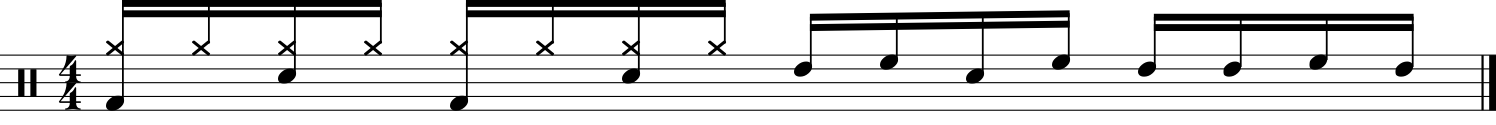

마디 몇 개?  2
16th 리듬 개수:  16
[(['G5', 'F4'], '16th'), (['G5'], '16th'), (['G5', 'C5'], '16th'), (['G5'], '16th'), (['G5', 'F4'], '16th'), (['G5'], '16th'), (['G5', 'C5'], '16th'), (['G5'], '16th'), (['E5'], '16th'), (['C5'], '16th'), (['D5'], '16th'), (['E5'], '16th'), (['C5'], '16th'), (['E5'], '16th'), (['D5'], '16th'), (['D5'], '16th')]
16th 리듬 개수:  16
[(['G5', 'F4'], '16th'), (['G5'], '16th'), (['G5', 'C5'], '16th'), (['G5'], '16th'), (['G5', 'F4'], '16th'), (['G5'], '16th'), (['G5', 'C5'], '16th'), (['G5'], '16th'), (['E5'], '16th'), (['D5'], '16th'), (['A4'], '16th'), (['A4'], '16th'), (['D5'], '16th'), (['A4'], '16th'), (['A4'], '16th'), (['C5'], '16th')]
[[(['G5', 'F4'], '16th'), (['G5'], '16th'), (['G5', 'C5'], '16th'), (['G5'], '16th'), (['G5', 'F4'], '16th'), (['G5'], '16th'), (['G5', 'C5'], '16th'), (['G5'], '16th'), (['E5'], '16th'), (['C5'], '16th'), (['D5'], '16th'), (['E5'], '16th'), (['C5'], '16th'), (['E5'], '16th'), (['D5'], '16th'), (['D5'], '16th')], [(['G5', 'F4'], 

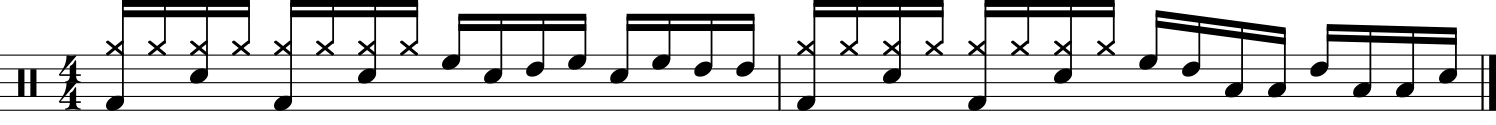

마디 몇 개?  2
quarter 리듬 개수:  4
[(['G5', 'F4'], 'quarter'), (['G5'], 'quarter'), (['E5'], 'quarter'), (['D5'], 'quarter')]
16th 리듬 개수:  16
[(['G5', 'F4'], '16th'), (['G5'], '16th'), (['G5', 'C5'], '16th'), (['G5'], '16th'), (['G5', 'F4'], '16th'), (['G5'], '16th'), (['G5', 'C5'], '16th'), (['G5'], '16th'), (['D5'], '16th'), (['D5'], '16th'), (['D5'], '16th'), (['A4'], '16th'), (['C5'], '16th'), (['C5'], '16th'), (['E5'], '16th'), (['D5'], '16th')]
[[(['G5', 'F4'], 'quarter'), (['G5'], 'quarter'), (['E5'], 'quarter'), (['D5'], 'quarter')], [(['G5', 'F4'], '16th'), (['G5'], '16th'), (['G5', 'C5'], '16th'), (['G5'], '16th'), (['G5', 'F4'], '16th'), (['G5'], '16th'), (['G5', 'C5'], '16th'), (['G5'], '16th'), (['D5'], '16th'), (['D5'], '16th'), (['D5'], '16th'), (['A4'], '16th'), (['C5'], '16th'), (['C5'], '16th'), (['E5'], '16th'), (['D5'], '16th')]]
[[(['G5', 'F4'], 'quarter'), (['G5'], 'quarter'), (['E5'], 'quarter'), (['D5'], 'quarter')], [(['G5', 'F4'], '16th'), (['G5'], '16th'), (['G5', 

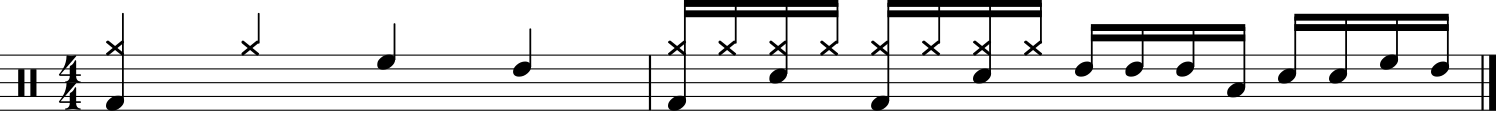

마디 몇 개?  2
16th 리듬 개수:  16
[(['G5', 'F4'], '16th'), (['G5'], '16th'), (['G5', 'C5'], '16th'), (['G5'], '16th'), (['G5', 'F4'], '16th'), (['G5'], '16th'), (['G5', 'C5'], '16th'), (['G5'], '16th'), (['C5'], '16th'), (['E5'], '16th'), (['C5'], '16th'), (['E5'], '16th'), (['C5'], '16th'), (['A4'], '16th'), (['D5'], '16th'), (['E5'], '16th')]
16th 리듬 개수:  16
[(['G5', 'F4'], '16th'), (['G5'], '16th'), (['G5', 'C5'], '16th'), (['G5'], '16th'), (['G5', 'F4'], '16th'), (['G5'], '16th'), (['G5', 'C5'], '16th'), (['G5'], '16th'), (['C5'], '16th'), (['E5'], '16th'), (['A4'], '16th'), (['A4'], '16th'), (['E5'], '16th'), (['D5'], '16th'), (['C5'], '16th'), (['A4'], '16th')]
[[(['G5', 'F4'], '16th'), (['G5'], '16th'), (['G5', 'C5'], '16th'), (['G5'], '16th'), (['G5', 'F4'], '16th'), (['G5'], '16th'), (['G5', 'C5'], '16th'), (['G5'], '16th'), (['C5'], '16th'), (['E5'], '16th'), (['C5'], '16th'), (['E5'], '16th'), (['C5'], '16th'), (['A4'], '16th'), (['D5'], '16th'), (['E5'], '16th')], [(['G5', 'F4'], 

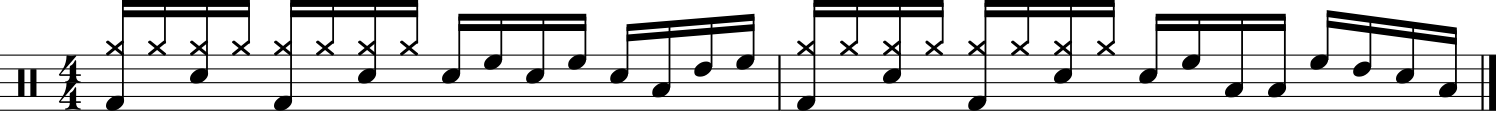

마디 몇 개?  1
16th 리듬 개수:  16
[(['G5', 'F4'], '16th'), (['G5'], '16th'), (['G5', 'C5'], '16th'), (['G5'], '16th'), (['G5', 'F4'], '16th'), (['G5'], '16th'), (['G5', 'C5'], '16th'), (['G5'], '16th'), (['C5'], '16th'), (['C5'], '16th'), (['E5'], '16th'), (['D5'], '16th'), (['E5'], '16th'), (['C5'], '16th'), (['C5'], '16th'), (['C5'], '16th')]
[[(['G5', 'F4'], '16th'), (['G5'], '16th'), (['G5', 'C5'], '16th'), (['G5'], '16th'), (['G5', 'F4'], '16th'), (['G5'], '16th'), (['G5', 'C5'], '16th'), (['G5'], '16th'), (['C5'], '16th'), (['C5'], '16th'), (['E5'], '16th'), (['D5'], '16th'), (['E5'], '16th'), (['C5'], '16th'), (['C5'], '16th'), (['C5'], '16th')]]
[[(['G5', 'F4'], '16th'), (['G5'], '16th'), (['G5', 'C5'], '16th'), (['G5'], '16th'), (['G5', 'F4'], '16th'), (['G5'], '16th'), (['G5', 'C5'], '16th'), (['G5'], '16th'), (['C5'], '16th'), (['C5'], '16th'), (['E5'], '16th'), (['D5'], '16th'), (['E5'], '16th'), (['C5'], '16th'), (['C5'], '16th'), (['C5'], '16th')]]
annotation clef-percussion+tim

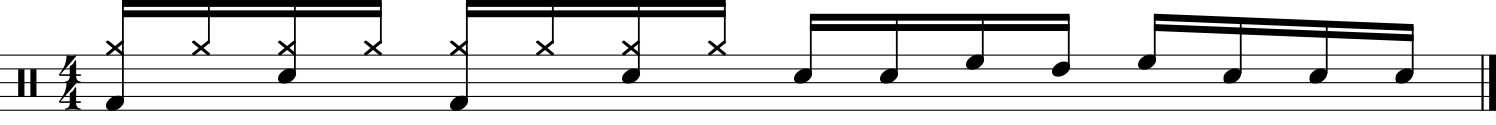

In [180]:
from music21 import note

print(note.Unpitched())
create_dataset_txt_xml(5)

### 🚀 Test code

#### first code

In [181]:
import random

def choose_rhythm(bias_rhythm):
    rhythm_choices = list(rhythm_probabilities[bias_rhythm].keys())
    probabilities = list(rhythm_probabilities[bias_rhythm].values())
    return random.choices(rhythm_choices, probabilities)[0]

def generate_measure(bias_rhythm):
    measure = []
    total_duration = 0.0
    while total_duration < 4.0:
        if random.choices([True, False], [note_prob, rest_prob])[0]:
            note = random.choices(instruments, probabilities)[0]
            num_simul = random.choices([1, 2, 3], simul_prob_counts[note])[0]
            if num_simul == 1:
                simult_notes = [note]
            else:
                possible_notes = [n for n in instruments if n != note]
                simul_prob = [simul_probabilities[note].get(n, 0) for n in possible_notes]
                simul_prob = [p / sum(simul_prob) for p in simul_prob]  # 확률을 정규화
                simult_notes = [note] + random.choices(possible_notes, simul_prob, k=num_simul-1)
            rhythm = choose_rhythm(bias_rhythm)
            duration = DURATION_TYPE_TO_LENGTH[rhythm]
            if total_duration + duration <= 4.0:
                measure.append((simult_notes, rhythm))
                total_duration += duration
        else:
            rhythm = choose_rhythm(bias_rhythm)
            duration = DURATION_TYPE_TO_LENGTH[rhythm]
            if total_duration + duration <= 4.0:
                measure.append((['Rest'], rhythm))
                total_duration += duration
    return measure

def generate_drum_sheet(num_measures):
    drum_sheet = []
    for _ in range(num_measures):
        bias_rhythm = random.choices([QUARTER, EIGHTH, SIXTEEN], [33, 34, 33])[0]
        measure = generate_measure(bias_rhythm)
        drum_sheet.append(measure)
    return drum_sheet

# 예시: 4개의 마디로 이루어진 드럼 악보 생성
num_measures = 4
drum_sheet = generate_drum_sheet(num_measures)
for i, measure in enumerate(drum_sheet):
    print(f"Measure {i + 1}:")
    for beat in measure:
        print(f"  {beat}")

Measure 1:
  (['G5'], '16th')
  (['G5', 'C5'], '16th')
  (['G5', 'A4'], '16th')
  (['G5', 'A4'], '16th')
  (['G5'], '16th')
  (['G5', 'C5'], '16th')
  (['G5'], '16th')
  (['G5', 'C5'], '16th')
  (['G5'], '16th')
  (['G5', 'C5'], '16th')
  (['G5', 'C5'], '16th')
  (['G5'], '16th')
  (['G5'], '16th')
  (['G5', 'C5', 'C5'], '16th')
  (['G5', 'C5', 'C5'], '16th')
  (['G5', 'F4'], '16th')
Measure 2:
  (['G5'], '16th')
  (['G5', 'C5'], '16th')
  (['G5', 'C5'], '16th')
  (['G5', 'F4', 'F4'], '16th')
  (['G5'], '16th')
  (['G5', 'C5'], '16th')
  (['G5', 'F4'], '16th')
  (['G5'], '16th')
  (['G5'], '16th')
  (['G5', 'C5'], '16th')
  (['G5', 'F4', 'D5'], '16th')
  (['G5'], '16th')
  (['G5', 'F4'], '16th')
  (['G5'], '16th')
  (['G5', 'D5', 'C5'], '16th')
  (['G5'], '16th')
Measure 3:
  (['G5', 'F4'], 'quarter')
  (['G5', 'F4'], 'quarter')
  (['G5'], 'quarter')
  (['G5', 'F4'], 'quarter')
Measure 4:
  (['G5', 'F4', 'D5'], 'quarter')
  (['G5'], 'quarter')
  (['G5', 'C5'], 'quarter')
  (['G5', 'C5'

#### second code

In [182]:
import random

# 함수: 주어진 기본 비트에 대한 리듬을 선택
def choose_rhythm(bias_rhythm):
    rhythm_choices = list(rhythm_probabilities[bias_rhythm].keys())
    probabilities = list(rhythm_probabilities[bias_rhythm].values())
    return random.choices(rhythm_choices, probabilities)[0]

# 함수: 한 마디를 생성
def generate_measure(bias_rhythm):
    measure = []
    total_duration = 0.0
    is_first_note = True

    print(bias_rhythm)
    while total_duration < 4.0:
        # 리듬 선택
        rhythm = choose_rhythm(bias_rhythm)
        duration = DURATION_TYPE_TO_LENGTH[rhythm]

        is_crash = False
        if is_first_note:
            is_first_note = False
            is_crash = random.choices([True, False], [80, 20])[0]  

        only_rest = False

        if duration > 1.0:
            only_rest = True

        # 음표인지 쉼표인지 결정
        if random.choices([True, False], [note_prob, rest_prob])[0]:
            if only_rest:
                continue

            note = random.choices(instruments, probabilities)[0]
            if is_crash:
                note = CRASH
            
            simult_notes = [note]

            # 동시에 친 음의 개수 결정
            num_simul = random.choices([1, 2, 3], simul_prob_counts[note])[0]
            if num_simul > 1 and simul_probabilities.get(note):
                possible_notes  = list(simul_probabilities[note].keys())
                possible_notes_prob = list(simul_probabilities[note].values())
                
                # 손으로 치는 악기 개수
                hand_cnt = 0
                if not note in foot_instruments:
                    hand_cnt = 1
                
                for _ in range(num_simul - 1):
                    # possible_notes_prob = [p / sum(possible_notes_prob) for p in possible_notes_prob]  # 확률을 정규화
                    chosen_note = random.choices(possible_notes, possible_notes_prob)[0]
                    if not chosen_note in foot_instruments:
                        hand_cnt += 1

                    simult_notes.append(chosen_note)
                    note_index = possible_notes.index(chosen_note)
                    possible_notes.remove(chosen_note)
                    possible_notes_prob.pop(note_index)

                    if hand_cnt == 2:
                        remove_notes = []
                        for d in possible_notes:
                            if not d in foot_instruments:
                                remove_notes.append(d)
                        
                        for r in remove_notes:
                            note_index = possible_notes.index(r)
                            possible_notes.remove(r)
                            possible_notes_prob.pop(note_index)

            # 마디 내에 리듬을 추가할 수 있는지 확인
            if total_duration + duration <= 4.0:
                measure.append((simult_notes, rhythm))
                total_duration += duration
        else:
            # 쉼표 생성
            rhythm = choose_rhythm(bias_rhythm)
            duration = DURATION_TYPE_TO_LENGTH[rhythm]
            if total_duration + duration <= 4.0:
                measure.append((['Rest'], rhythm))
                total_duration += duration
    return measure

# 함수: 드럼 악보 생성
def generate_drum_sheet():
    num_measures = random.randint(BAR_MIN, BAR_MAX)
    print(num_measures)
    drum_sheet = []
    for _ in range(num_measures):
        bias_rhythm = random.choices(bias_rhythms, bias_rhythms_prob)[0]
        measure = generate_measure(bias_rhythm)
        drum_sheet.append(measure)
    return drum_sheet

# 드럼 악보 생성
drum_sheet = generate_drum_sheet()
for i, measure in enumerate(drum_sheet):
    print(f"Measure {i + 1}:")
    for beat in measure:
        print(f"  {beat}")


3
quarter
16th
16th
Measure 1:
  (['A5'], 'quarter')
  (['G5'], 'quarter')
  (['G5', 'C5', 'F4'], 'quarter')
  (['G5'], 'quarter')
Measure 2:
  (['A5', 'C5'], '16th')
  (['G5', 'F4'], '16th')
  (['G5', 'C5', 'F4'], '16th')
  (['G5'], '16th')
  (['G5'], '16th')
  (['G5', 'F4'], '16th')
  (['G5'], '16th')
  (['G5', 'F4'], '16th')
  (['G5'], '16th')
  (['G5', 'C5'], '16th')
  (['G5'], '16th')
  (['G5', 'F4'], '16th')
  (['G5', 'F4'], '16th')
  (['G5', 'C5'], '16th')
  (['G5', 'C5'], '16th')
  (['G5', 'C5'], '16th')
Measure 3:
  (['A5'], '16th')
  (['G5', 'F4'], '16th')
  (['G5', 'F4', 'C5'], '16th')
  (['G5', 'C5'], '16th')
  (['G5', 'F4'], '16th')
  (['G5', 'C5'], '16th')
  (['G5', 'C5'], '16th')
  (['G5', 'C5'], '16th')
  (['G5'], '16th')
  (['G5', 'C5'], '16th')
  (['G5'], '16th')
  (['G5', 'D5'], '16th')
  (['G5', 'F4'], '16th')
  (['G5'], '16th')
  (['G5', 'D5'], '16th')
  (['G5'], '16th')


In [183]:
def convert_to_annotation(drum_sheet):
    annotation = "clef-percussion+timeSignature-4/4+"
    for measure in drum_sheet:
        for beat in measure:
            notes, rhythm = beat
            if notes == ['Rest']:
                annotation += f"rest_{rhythm}"
            else:
                note_str = '|'.join([f"note-{note}_{rhythm}" for note in notes])
                annotation += note_str
            annotation += "+"
        annotation += "barline"
    return annotation.strip()

# 예시 악보를 annotation 형식으로 변환
annotation_result = convert_to_annotation(drum_sheet)
print(annotation_result)


clef-percussion+timeSignature-4/4+note-A5_quarter+note-G5_quarter+note-G5_quarter|note-C5_quarter|note-F4_quarter+note-G5_quarter+barlinenote-A5_16th|note-C5_16th+note-G5_16th|note-F4_16th+note-G5_16th|note-C5_16th|note-F4_16th+note-G5_16th+note-G5_16th+note-G5_16th|note-F4_16th+note-G5_16th+note-G5_16th|note-F4_16th+note-G5_16th+note-G5_16th|note-C5_16th+note-G5_16th+note-G5_16th|note-F4_16th+note-G5_16th|note-F4_16th+note-G5_16th|note-C5_16th+note-G5_16th|note-C5_16th+note-G5_16th|note-C5_16th+barlinenote-A5_16th+note-G5_16th|note-F4_16th+note-G5_16th|note-F4_16th|note-C5_16th+note-G5_16th|note-C5_16th+note-G5_16th|note-F4_16th+note-G5_16th|note-C5_16th+note-G5_16th|note-C5_16th+note-G5_16th|note-C5_16th+note-G5_16th+note-G5_16th|note-C5_16th+note-G5_16th+note-G5_16th|note-D5_16th+note-G5_16th|note-F4_16th+note-G5_16th+note-G5_16th|note-D5_16th+note-G5_16th+barline
